In [26]:
!pip3 install pydotplus
!pip install graphviz

In [2]:
import statistics 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image
#confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix


## Load dataset

In [3]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

## Transform categorical features into numerical ones

In [4]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [5]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [6]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [7]:
df.describe()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,hand_num,gender_num,ioc_num
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.00000,2072.000000,2072.000000,2072.000000
mean,0.486609,100.942085,0.478162,23.541988,0.309913,1993.805502,179.104946,80.432832,6.716569,0.523839,871.927124,7.450516,43.113605,6.698571,6.355497,54.31431,1.176641,0.505792,44.944498
std,0.115073,78.005562,0.134808,26.280039,0.264866,5.063032,8.008870,16.122646,5.324856,0.146481,720.860044,3.444339,12.302156,4.583606,1.962237,19.24605,0.571050,0.500087,29.383334
min,0.133333,0.000000,0.000000,0.000000,0.000000,1977.000000,157.000000,55.472222,0.000000,0.037581,0.000000,0.000000,0.000000,0.070000,0.000000,0.91000,0.000000,0.000000,0.000000
25%,0.423077,28.000000,0.415466,0.000000,0.000000,1990.000000,173.000000,62.607850,2.400000,0.505333,230.000000,5.220000,40.770000,2.550000,5.390000,39.42750,1.000000,0.000000,20.000000
50%,0.500000,82.000000,0.500000,12.000000,0.375000,1994.000000,178.000000,82.359127,5.755000,0.580575,638.500000,6.950000,47.295000,6.155000,6.615000,64.30500,1.000000,1.000000,41.000000
75%,0.565673,170.000000,0.566866,45.000000,0.533333,1998.000000,185.705882,94.008066,9.840000,0.614162,1446.500000,9.172500,50.112500,10.312500,7.552500,69.80000,2.000000,1.000000,73.000000
max,0.845161,309.000000,1.000000,101.000000,1.000000,2006.000000,198.000000,145.073643,35.390000,0.949992,3834.000000,29.860000,94.180000,23.310000,17.890000,80.79000,2.000000,1.000000,95.000000


## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli.

Nota: questa non è una metrica efficate perchè il vero label del giocatore viene calcolato in base al relativo ranking ma nel nostro caso avendo molti null risulta difficile stimarlo quindi se non ci sono altre alternative potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili

In [8]:
# label tipo1
quantile_a = df.ratio.quantile(0.33)
quantile_b = df.ratio.quantile(0.66)

# label tipo2
#quantile_a = df.ratio.quantile(0.25)
#quantile_b = df.ratio.quantile(0.75)

In [38]:
labels = []
for customer, ratio in df.ratio.items():
    if ratio < quantile_a:
        labels.append(0)
    elif ratio > quantile_b:
        labels.append(2)
    else:
        labels.append(1)

In [39]:
class_names = ['low-level', 'medium-level', 'high-level']

In [40]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts()

2    705
1    684
0    683
Name: labels, dtype: int64

### Prepare dataset (splitting)

In [12]:
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.30)

# Classification 

## Classfication with decision tree

### Grid Search

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

dt_max_depth = [2,3,5,6,7,10,12, None]
dt_min_samples_split = randint(2, 51)
min_samples_leaf = randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features
            }

#define the number of iters (random combination to try)
n_iter_search = 500

#define the number of jobs to run in parallel
n_jobs_search = -1

#define the grid search
dt_grid = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distributions=dt_param_grid, 
                            n_iter=n_iter_search,  
                            n_jobs=n_jobs_search,
                            scoring=make_scorer(accuracy_score))

In [14]:
dt_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': [None, 2, 3, 4, 5],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd8a3a0070>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd8a2e6fd0>,
                                        'splitter': ['best', 'random']},
                   scoring=make_scorer(accuracy_score))

In [15]:
print(dt_grid.best_params_)


{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 22, 'min_samples_split': 20, 'splitter': 'best'}


### Training

In [34]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=11, min_samples_leaf=7)
dt = dt.fit(train_set, train_label)

In [27]:
#visualize the actual decision tree obtained  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=class_names,  
                         filled=True, rounded=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


InvocationException: GraphViz's executables not found

In [35]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix


In [36]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  1.0
Accuracy test set  1.0
Precision train set  1.0
Recall train set  1.0
F1 score train set  1.0
Support train set  (array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([478, 479, 493]))


In [37]:
#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=class_names))

In [21]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

   low-level       1.00      1.00      1.00       205
medium-level       1.00      1.00      1.00       205
  high-level       1.00      1.00      1.00       212

    accuracy                           1.00       622
   macro avg       1.00      1.00      1.00       622
weighted avg       1.00      1.00      1.00       622



In [22]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.007978121439615885
Score time  0.0022613207499186196
Test score  1.0
Train score  1.0


In [23]:

cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[205,   0,   0],
       [  0, 205,   0],
       [  0,   0, 212]])

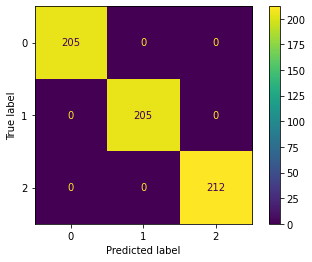

In [24]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

## Other Classification technique